---
# Modelling hippocampal neurons of animals navigating in VR with recurrent neural networks
### Marco P. Abrate, Daniel Liu
---

##### Outline
Rat simulation:
- Motion model (RatInABox)
- Environment design (Blender)
- Simulated rat vision (ratvision)

Vision autoencoder

Hippocampus model (RNN):
- RNN definition
- Data loading
- Training

Hidden state representations analysis:
- Rate maps
- Polar maps
- Quantitive metrics
- Comparison with real data

### **Part 3: Modelling the hippocampus with an RNN**
##### made by: Daniel Liu, Marco Abrate, UCL
---
In this notebook, we will write code to define the Recurrent Neural Network (**RNN**), which will serve as the model of the hippocampus.

RNNs are models designed to process sequential data by retaining memory over time. Specifically in this tutorial, we train an RNN to perform a **next-step prediction task** on a self-supervised task.

What is next-step prediction and why?



Prerequisites:

* Completed Notebook 1

Before starting this notebook, make sure you have:
- video recordings from part 1,
- trajectory data from part 1, including speed and rotational speed at each time step,
- embedded video recordings in ```.npy``` format from the Vision Autoencoder we trained in the last tutorial.


### **0. Install and import dependencies**

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from IPython.display import clear_output
import time

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

### **1. Load data**

In [ ]:
# load the embeddings and trajectory data
train_embeddings = None
train_speed = None
train_rot_vels = None
train_hds = None
train_thetas = None
train_pos = None

# test_embeddings, ...

assert train_embeddings.shape[0] == train_speed.shape[0] == train_rot_vels.shape[0]

visual_embedding_dim = train_embeddings.shape[-1]
motion_signal_dim = train_speed.shape[-1] + train_rot_vels.shape[-1]

### 1 Defining an RNN

Let's define a recurrent neural network. This network will use a pre-defined ```RNNModule``` class, which we have provided, that employs Sigmoidal activation functions when projecting inputs to hidden states. The hidden states are then projected to predict the next sensory state via a linear layer. 

The sigmoidal function compresses the hidden states to between 0 and 1, which can be interpreted as the (scaled) activity of each neuron.

In [ ]:
class PathIntegrationRNN(nn.Module):
    '''
    This class implements a simple RNN that uses current step sensory input, motion signals,
    and the previous hidden state to predict the next step sensory input.
    The RNN is expected to learn to integrate the sensory inputs over time, effectively simulating
    path integration.
    '''
    def __init__(self, input_dim, hidden_dim, output_dim, device):
        super(PathIntegrationRNN, self).__init__()

        self.device = device
        self.rnn = RNNModule(n_inputs =input_dim, n_hidden=hidden_dim, nonlinearity='sigmoid', device=device)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.to(device)
        
    def forward(self, x, hidden):
        
        # COMPLETE THE CODE HERE: 
        # x should be of shape (batch_size, seq_length, input_dim)
        raise NotImplementedError
        
        # out, hidden = self.rnn(x, hidden)
        # out = self.fc(out)
        # return out, hidden

Note that our input dimension would be the both the visual embedding dimension and the motion signal.

In [ ]:
rnn = PathIntegrationRNN(input_dim=visual_embedding_dim + motion_signal_dim,
                         hidden_dim=50,
                         output_dim=visual_embedding_dim).to(device)

### 2 Defining a DataLoader

To allow our RNN to perform the next-state prediction task, we need to use a **Dataset** and **DataLoader**. The **Dataset** prepares sensory embeddings as well as motion signals to batches of paired inputs and labels; the **DataLoader** sequentially generates these batches during training and testing.

The Dataset and Dataloader classes will inherit PyTorch's built-in ```torch.utils.data.Dataset``` and ```torch.utils.data.DataLoader``` classes.

In [ ]:
class SensoryDataset(torch.utils.data.Dataset):
    def __init__(self, embs, vels, rot_vels, hds, thetas, pos, tsteps=9, n_future_pred=1):
        '''
        The initialisation function for the SensoryDataset class.
        At initialisation, all embeddings are converted to tensors.
        Args:
            embs: The visual embeddings of shape (N, D)
            vels: The speed signals of shape (N, 1)
            rot_vels: The rotational velocities of shape (N, 1)
            hds: The headings of shape (N, 1)
            thetas: The headings of shape (N, 1)
            tsteps: The number of time steps for each batch. 
                    By default, this is set to 9 i.e. we use the sensory input from steps 1 to 9
            n_future_pred: The number of steps into the future to predict.
                    By default, this is set to 1 i.e. we predict the sensory input at steps 2 to 10            
        '''
        
        self.embs = torch.tensor(embs, dtype=torch.float32)
        self.vels = torch.tensor(vels, dtype=torch.float32)
        self.rot_vels = torch.tensor(rot_vels, dtype=torch.float32)
        self.hds = torch.tensor(hds, dtype=torch.float32)
        self.thetas = torch.tensor(thetas, dtype=torch.float32)
        self.pos = torch.tensor(pos, dtype=torch.float32)
        
        self.tsteps = tsteps
        self.n_future_pred = n_future_pred
        
        del embs, vels, rot_vels, hds, thetas # free up memory
    
    def __len__(self):
        # COMPLETE THE CODE HERE: how many samples are in the dataset?
        return self.embs.shape[0] // self.tsteps - self.n_future_pred
    
    def __getitem__(self, idx):
        '''
        This function returns a batch of sensory inputs and the corresponding future sensory inputs.
        Args:
            idx: The index of the sample to return.
        Returns:
            A tuple containing:
                - sensory_inputs: A tensor of shape (tsteps, input_dim) containing the sensory inputs
                - future_sensory_inputs: A tensor of shape (n_future_pred, input_dim) containing the future sensory inputs
        '''
        embs, vels, rot_vels, pos, hds, thetas, embs_labels = [], [], [], [], [], [], []
        embs = self.embs[idx * self.tsteps:(idx + 1) * self.tsteps]
        
        start_idx, end_idx = idx * self.tsteps, (idx + 1) * self.tsteps
        
        for future_step in range(self.n_future_pred):
            # COMPLETE THE CODE HERE: 
            # Get the sensory inputs and future sensory inputs for the given index
            pass
        
            # vels.append(self.vels[:, start_idx + future_step: end_idx + future_step])
            # rot_vels.append(self.rot_vels[:, start_idx + future_step: end_idx + future_step])
            # pos.append(self.pos[:, start_idx + future_step: end_idx + future_step])
            # hds.append(self.hds[:, start_idx + future_step: end_idx + future_step])
            # thetas.append(self.thetas[:, start_idx + future_step: end_idx + future_step])
            
            # embs_labels.append(embs[:, start_idx + future_step + 1: end_idx + future_step + 1])
        
        vels, rot_vels, pos, hds, thetas, embs_labels = torch.vstack(vels, dim=1), \
                                                        torch.vstack(rot_vels, dim=1), \
                                                        torch.vstack(pos, dim=1), \
                                                        torch.vstack(hds, dim=1), \
                                                        torch.vstack(thetas, dim=1), \
                                                        torch.vstack(embs_labels, dim=1) 
        
        return embs, vels, rot_vels, pos, hds, s, embs_labels

# very important: we do not shuffle the datasets because hidden states are dependent on the previous batch
train_dataloader = torch.utils.data.DataLoader(
        SensoryDataset(train_embeddings, train_speed, train_rot_vels, train_hds, train_thetas, train_pos, tsteps=9, n_future_pred=1),
        shuffle=False)

# test_dataloader = ...

### 3 Writing an RNN training function

Training the RNN is similar to training the autoencoder, except that we need to **pass the hidden state from one batch to another** i.e. batches are now sequential rather than independent.

In [ ]:
def train_rnn_epoch(rnn, dataloader, optim, loss_fn, scheduler, device):
    '''
    This function trains the RNN for one epoch. 
    We will default to only predcting the next step sensory input,
    i.e. n_future_pred = 1.
    '''
    rnn.train()
    
    batch_losses = []
    h_t = None  # Initialize hidden state as zeros
    for i, data in enumerate(dataloader):
        embs, vels, rot_vels, _, _, _, embs_labels = data
        
        # COMPLETE THE CODE HERE: 
        inputs = None
        outputs, h_t = None, None
        
        # inputs = torch.cat((embs, vels, rot_vels), dim=-1).to(device)
        # outputs, h_t = rnn(inputs, h_t)
        
        loss = loss_fn(outputs, embs_labels.to(device))
        batch_losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
        if scheduler is not None: scheduler.step()
        h_t = h_t.detach()  # Detach hidden state to prevent backpropagation through the entire history
        
    return batch_losses 

A paired test function has been provided for convenience. This function additionally saves the hidden state at each step. This is needed for computing the rate maps in the later parts of this tutorial. It is structured like this:

```python
def test_rnn_epoch(rnn, dataloader, loss_fn, stepwise=True):
    ...
    return test_dict    
```

Where, ```test_dict``` is a dictionary containing the following keys:
* ```batch_losses```;
* ```h_ts```, the hidden state at each time step;
* ```pos```, the (x, y) position of the agent at each time step;
* ```hds``, the (dx, dy) direction of the agent at each time step as a unit circle;
* ```thetas```, the head bearing of the agent at each time step.

This function will be imported below.

In [ ]:
from utils import test_rnn_epoch

### 4 Putting it all together

We will define some parameters for training, then train the RNN.

In [ ]:
# define some training parameters
loss_fn = None
init_lr = 1e-3
optim = torch.optim.Adam(rnn.parameters(), lr=init_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)
n_epochs = 1000

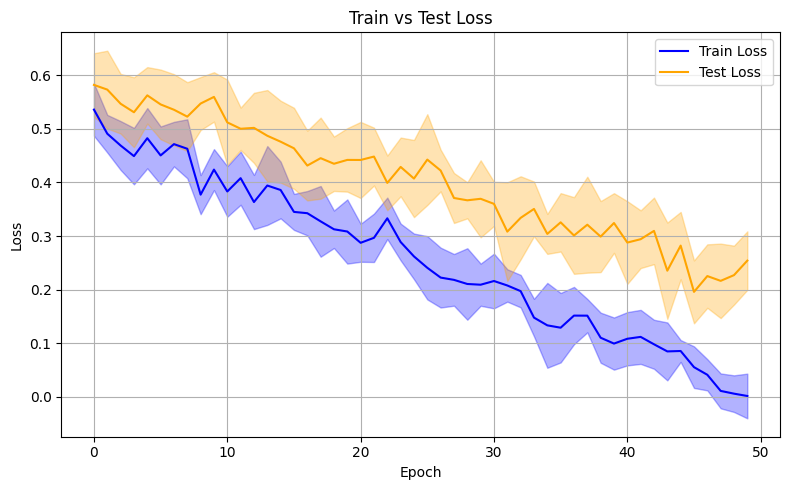

In [ ]:
train_means, test_means = [], []
train_stds, test_stds = [], []
epochs = []

# Main training loop
for epoch in range(n_epochs):
    # COMPLETE THE CODE HERE: train the RNN for one epoch, then test it
    train_losses = None
    test_dict = None
    
    # train_losses = train_rnn_epoch(rnn, train_dataloader, optim, loss_fn, scheduler)
    # test_losses = test_rnn_epoch(rnn, train_dataloader, loss_fn)
    test_losses = test_dict['batch_losses']
    
    train_mean, train_std = np.mean(train_losses), np.std(train_losses)
    test_mean, test_std = np.mean(test_losses), np.std(test_losses)

    train_means.append(train_mean)
    train_stds.append(train_std)
    test_means.append(test_mean)
    test_stds.append(test_std)
    epochs.append(epoch)

    # Clear previous plot output
    clear_output(wait=True)
    
    # Create new plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_means, label='Train Loss', color='blue')
    plt.fill_between(
        epochs,
        np.array(train_means) - np.array(train_stds),
        np.array(train_means) + np.array(train_stds),
        color='blue', alpha=0.3
    )
    plt.plot(epochs, test_means, label='Test Loss', color='orange')
    plt.fill_between(
        epochs,
        np.array(test_means) - np.array(test_stds),
        np.array(test_means) + np.array(test_stds),
        color='orange', alpha=0.3
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Test Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    time.sleep(0.1)  # wait a bit to simulate training

### **What have we achieved in this tutorial?**

We trained a recurrent neural network to perform the next-step prediction task.

In the next tutorial, we will look into how to extract realistic place cell rate maps from this RNN.